In [23]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [6]:
train_file_link = 'train.csv'

In [11]:
train_data = pd.read_csv(train_file_link,header = 0, delimiter = ',', quoting = 3)
train_data.head(10)

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0
5,6,2017-01,행복한주말보내세요XXX용현남전담직원대리 XXX올림,0
6,7,2017-01,XXX 고객님 안녕하세요XXX은행 무교지점 XXX과장입니다 오늘 아침에 눈을 뜨니 ...,0
7,8,2017-01,XXX 고객님지난 한해 베풀어 주신 은혜 진심으로 감사 드립니다.가슴 깊이 간직 하...,0
8,9,2017-01,설연휴 가족들과 훈훈한 정 나누시고 정겨운추억 많이 만드세요XXX오XXX올림,0
9,10,2017-01,(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...,1


In [13]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 295945


In [15]:
train_lenght = train_data['text'].astype(str).apply(len)

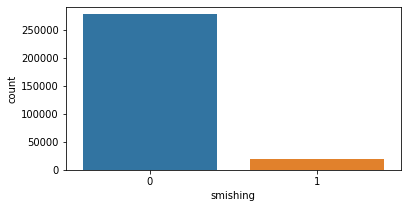

In [18]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['smishing'])

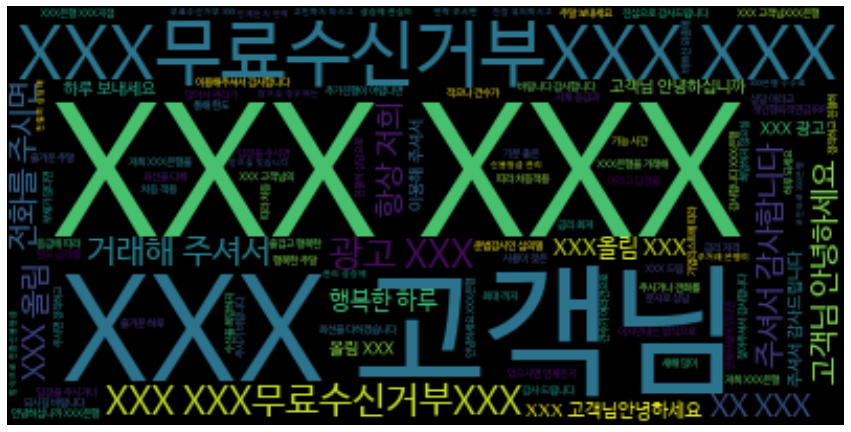

In [22]:
import matplotlib.font_manager as fm
fontpath = 'NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

train_review = [review for review in train_data['text'] if type(review) is str]
wordcloud = WordCloud(font_path=fontpath).generate(' ' .join(train_review))
plt.figure(figsize = (15 , 10))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

In [25]:
qmarks = np.mean(train_data['text'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['text'].astype(str).apply(lambda x: '.' in x)) # 마침표

In [26]:
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

In [27]:
train_data.head(10)

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0
2,2,2017-01,안녕하십니까 고객님. XXX은행입니다.금일 납부하셔야 할 금액은 153600원 입니...,0
3,4,2017-01,XXX 고객님안녕하세요XXX은행 XXX지점입니다지난 한 해 동안 저희 XXX지점에 ...,0
4,5,2017-01,1월은 새로움이 가득XXX입니다.올 한해 더 많이행복한 한해되시길바랍니다,0
5,6,2017-01,행복한주말보내세요XXX용현남전담직원대리 XXX올림,0
6,7,2017-01,XXX 고객님 안녕하세요XXX은행 무교지점 XXX과장입니다 오늘 아침에 눈을 뜨니 ...,0
7,8,2017-01,XXX 고객님지난 한해 베풀어 주신 은혜 진심으로 감사 드립니다.가슴 깊이 간직 하...,0
8,9,2017-01,설연휴 가족들과 훈훈한 정 나누시고 정겨운추억 많이 만드세요XXX오XXX올림,0
9,10,2017-01,(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...,1


In [29]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['text'][5]) 
print(review_text)

행복한주말보내세요용현남전담직원대리 올림


In [30]:
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['행복하다', '보내다', '용', '현남', '전담', '직원', '대리', '올리다']


In [31]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['행복하다', '보내다', '용', '현남', '전담', '직원', '대리', '올리다']


In [32]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [34]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data['text']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

100%|████████████████████████████████████████████████████████████████████████| 295945/295945 [1:02:46<00:00, 78.58it/s]


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
train_labels = np.array(train_data['smishing']) 

In [37]:
MAX_SEQUENCE_LENGTH = 100 

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화

In [38]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.VERSION

'1.14.0'

In [39]:
input_data = train_inputs
label_data = train_labels
word_vocab = tokenizer.word_index

In [40]:
TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = len(word_vocab) + 1
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 1

In [41]:
input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)

In [42]:
def mapping_fn(X, Y):
    input, label = {'x': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=len(input_train))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    dataset = dataset.repeat(count=NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
    dataset = dataset.batch(128)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [43]:
def cnn_model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    embedding_layer = tf.keras.layers.Embedding(
                    VOCAB_SIZE,
                    EMB_SIZE)(features['x'])

    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
    
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', 
                                  activation=tf.nn.relu)(dropout_emb)
    
  
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(pool)   


    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

In [44]:
cnn_est = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\지소현\\AppData\\Local\\Temp\\tmpj7ckbur0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BD0E0062C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [45]:
cnn_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoi

INFO:tensorflow:global_step/sec: 16.9056
INFO:tensorflow:loss = 1.1773177e-06, step = 5901 (5.914 sec)
INFO:tensorflow:global_step/sec: 16.829
INFO:tensorflow:loss = 9.834771e-07, step = 6001 (5.943 sec)
INFO:tensorflow:global_step/sec: 16.7727
INFO:tensorflow:loss = 3.011126e-06, step = 6101 (5.962 sec)
INFO:tensorflow:global_step/sec: 16.9571
INFO:tensorflow:loss = 7.1813506e-06, step = 6201 (5.897 sec)
INFO:tensorflow:global_step/sec: 16.8715
INFO:tensorflow:loss = 3.7465106e-05, step = 6301 (5.927 sec)
INFO:tensorflow:global_step/sec: 16.9028
INFO:tensorflow:loss = 4.9174545e-05, step = 6401 (5.917 sec)
INFO:tensorflow:global_step/sec: 16.8971
INFO:tensorflow:loss = 2.499491e-05, step = 6501 (5.917 sec)
INFO:tensorflow:global_step/sec: 16.8914
INFO:tensorflow:loss = 4.7293347e-06, step = 6601 (5.920 sec)
INFO:tensorflow:global_step/sec: 16.9228
INFO:tensorflow:loss = 0.0001085593, step = 6701 (5.914 sec)
INFO:tensorflow:global_step/sec: 16.5512
INFO:tensorflow:loss = 2.5287015e-06,

INFO:tensorflow:global_step/sec: 15.5285
INFO:tensorflow:loss = 1.8888895e-07, step = 13801 (6.442 sec)
INFO:tensorflow:global_step/sec: 14.7171
INFO:tensorflow:loss = 0.023709547, step = 13901 (6.794 sec)
INFO:tensorflow:global_step/sec: 14.2607
INFO:tensorflow:loss = 2.8671343e-06, step = 14001 (7.012 sec)
INFO:tensorflow:global_step/sec: 12.499
INFO:tensorflow:loss = 6.740775e-09, step = 14101 (8.004 sec)
INFO:tensorflow:global_step/sec: 15.748
INFO:tensorflow:loss = 2.2720559e-07, step = 14201 (6.346 sec)
INFO:tensorflow:global_step/sec: 16.1957
INFO:tensorflow:loss = 3.6937945e-07, step = 14301 (6.174 sec)
INFO:tensorflow:global_step/sec: 16.1046
INFO:tensorflow:loss = 2.1064338e-08, step = 14401 (6.210 sec)
INFO:tensorflow:global_step/sec: 16.1487
INFO:tensorflow:loss = 1.2163497e-07, step = 14501 (6.195 sec)
INFO:tensorflow:global_step/sec: 16.2271
INFO:tensorflow:loss = 1.5225048e-07, step = 14601 (6.159 sec)
INFO:tensorflow:global_step/sec: 15.6034
INFO:tensorflow:loss = 2.142

In [46]:
cnn_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-02T15:01:24Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\지소현\AppData\Local\Temp\tmpj7ckbur0\model.ckpt-16647
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-01-02-15:01:27
INFO:tensorflow:Saving dict for global step 16647: acc = 0.9998311, global_step = 16647, loss = 0.001304748
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16647: C:\Users\지소현\AppData\Local\Temp\tmpj7ckbur0\model.ckpt-16647


{'acc': 0.9998311, 'loss': 0.001304748, 'global_step': 16647}

In [49]:
test_file_link = 'public_test.csv'

In [53]:
test_data = pd.read_csv(test_file_link, header = 0, delimiter = ',', quoting = 3)
clean_test_review = []

for review in tqdm(test_data['text']):
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])

test_sequences = tokenizer.texts_to_sequences(clean_test_review)
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
#test_labels = np.array(test_data['label']) # 학습 데이터의 라벨

100%|██████████████████████████████████████████████████████████████████████████████| 1626/1626 [00:30<00:00, 53.39it/s]


In [55]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))
    dataset = dataset.batch(128)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [57]:
def serving_input_receiver_fn():
    receiver_tensor = {
        'x': tf.placeholder(dtype=tf.string, shape=[None])
    }
    features = {
        key: tensor
        for key, tensor in receiver_tensor.items()
    }
    fn = lambda query: tf.decode_raw(query, tf.int64)
    features['x'] = tf.map_fn(fn, features['x'], dtype=tf.int64)
    features['x'] = tf.reshape(features['x'], [-1, MAX_SEQUENCE_LENGTH])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

In [62]:
export_dir_base = 'Untitled1'
path = cnn_est.export_savedmodel(export_dir_base, serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from C:\Users\지소현\AppData\Local\Temp\tmpj7ckbur0\model.ckpt-16647
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Untitled1\temp-b'1577945630'\saved_model.pb


In [63]:
def str2vec(s, okt, tokenizer, limit_len=MAX_SEQUENCE_LENGTH):
    tokenized_s = preprocessing(s, okt)
    sequences = tokenizer.texts_to_sequences([tokenized_s])
    sequences = pad_sequences(sequences, maxlen=limit_len, padding='post')
    return np.int64(sequences).tostring()

In [65]:
predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = path,
    # 옵션이지만 실행되는 모델에 대한 이름을 명시하고자 한다면 다음의 파라메터를 활용한다.
    signature_def_key="serving_default"
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from Untitled1\1577945630\variables\variables


In [68]:
test_sent = '간편신규https:obank.kbstar.comquics?pageC041244XXXhemekbbankpageidC054086인뱅페이지 예금https:obank.kbstar.comquics?pageC016613ccb061496:b061645prcodeDP000940인뱅페이지 대출 https:obank.kbstar.comquics?pageC019478ccb061479:b061589prcodeLN000260XXX은행데이터XXX올림'
model_input = str2vec(test_sent, okt, tokenizer)
predicted_value = predictor_fn({'x': [model_input]})
print('모델에서 반환된 값: ', predicted_value)
print('감정 예측 값 (0~1범위): ',  predicted_value['prob'][0][0])
input_str = input('input text : ')
model_input = str2vec(test_sent, okt, tokenizer)
predicted_value = predictor_fn({'x': [model_input]})
print(predicted_value['prob'][0])

모델에서 반환된 값:  {'prob': array([[0.]], dtype=float32)}
감정 예측 값 (0~1범위):  0.0
input text : (광고)다사다난했던 병신()년을 보내고 새로운 정유()년에는 늘 좋은 일과 뜻하시는 소망을 이루시는 새해가 되시기 바랍니다.저희 XXX과 기존 거래가 없으셨던  4대보험적용 되시는 직장인분들께도 새로운 금리체계로 보다 많은은행의 혜택을 드리고자 직장인 신용 대출 상품을 출시하였습니다.지금 사용중인 신용대출을 잘 확인하시고 잘못된 상품을 사용중이라면 심사숙고 하셔서 바꿔보시는게 어떠실까요?  신용대출상품- 최저금리 3.18%- 월급여의 최고 21배까지 한도 확대.(최고 1억2천가능)- 연봉의 2배까지 신용부채가 있어도 가능.- 신용조회 기록 남지 않음.- 1억2천 한도내에서 언제든 대출가능.- 여러 건의 부채를 통합 하실수 있는 기회.- 타사 신용대출 금리와 비교해 보시면 좋으세요. 1천만원 대출시 매월 평균 이자 13000원납부 (5년기준)(원금이자 한달 18만원 정도 부과됨.) 카드론 및 XXX XXX 상품 이용시는 분은 추천해 드립니다.꼭 이용을 하시라고 문자를 드리는게 아닙니다.궁금하신 내용이 있으시거나 혹은 상담을 받아야 겠다고 느끼시거나 추가로 필요하시거나여러 건의 부채 통합을 원하시거나 한달 월불입금이 많으셔서 계속 현금서비스나 카드론 대출이 늘어난다고생각이 드시면 주저 없이 연락주시기 바랍니다.특히 XXX이나 XXX 4금융권을 쓰고계신분들은 꼭연락부탁드립니다.30%대정도되시는 금리를 10%대로 갈아타셔도 엄청난 이자 절감을하실수있으십니다예를들어 2000만원을 (2금융권4금융권)쓰고계신다면 30%대에서 10%대로만 바꾸신다면 2000만원에서 20%로1년에 400만원을 이자절감하실수 있으시고 평균 5년짜리 상품을쓰신다는가정하에 5년동안 2000만원을절감할수 있는기회가 되시니 전화주셔서 저렴한 금리로 부채통합하시길 바랍니다내선전화가 통화중이거나 부재중일경우H: XXX-XXX-XXX(상담사:XXX)로상